In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Rectangle
from scipy.spatial.distance import cdist
from scipy.interpolate import RBFInterpolator
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances
from shapely.geometry import Point, Polygon, box
import sys
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation')
from visualisation_funcs import *

### Setup

In [3]:
# Resolution for the histogram (in meters)
kResolution = 200

# Flag and parameters for applying the log transformation (making the image more contrasted)
kApplyLog = True
kLogLengthscale = 1 # The bigger the more contrasted

# Flag to compute and show contours
kShowContour = True

# Smoothing parameters the bigger the smoother
kSmoothingFactor = 2

# Contour parameters
kContourFactor = 1.5 # The bigger the "larger" the contours
kContourMarkerSize = 0.5 # Marker size for visualization

# Output image resolution (under 100 starts to be quite slow)
kImgRes = 200

kQuestionValues = {20544:1, 20745:1, 20749:1, 20545:-1, 20746:-1, 20750:-1}

In [4]:
# Read the data
data = pd.read_csv('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation\\data\\cluster_data_15_6th.csv')

# sort data by id_person
data = data.sort_values(by=['id_person'])

# remove data where id_question is not in kQuestionValues
data = data[data['id_question'].isin(list(kQuestionValues.keys()))]

# add a 'question_value' column using kQuestionValues to convert questions to +/- 1
data['question_value'] = data['id_question'].map(kQuestionValues)

# import index
index = pd.read_csv('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\HPM take 2\\Sydney_walk_241122.csv')
index_max = index['THERE_Index'].max()
index_min = index['THERE_Index'].min()

x_maxd, x_mind, y_maxd, y_mind = data['x'].max(), data['x'].min(), data['y'].max(), data['y'].min()
x_maxi, x_mini, y_maxi, y_mini = index['x'].max(), index['x'].min(), index['y'].max(), index['y'].min()

Text(0.5, 1.0, 'red: survey data extent, blue: index data extent')

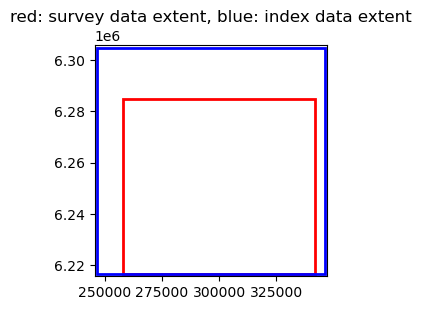

In [41]:
# plot bounding box of each set of data, just to check which is larger
fig, ax = plt.subplots(1, figsize=(3,3))
rectd = Rectangle((x_mind, y_mind), x_maxd-x_mind, y_maxd-y_mind, fill=False, edgecolor='red', linewidth=2)
recti = Rectangle((x_mini, y_mini), x_maxi-x_mini, y_maxi-y_mini, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(rectd)
ax.add_patch(recti)
ax.set_xlim([min(x_mind, x_mini)-1000, max(x_maxd, x_maxi)+1000])
ax.set_ylim([min(y_mind, y_mini)-1000, max(y_maxd, y_maxi)+1000])
ax.set_title('red: survey data extent, blue: index data extent')

## Creation of additional points for circled responses

In [6]:
# import hulls
hulls = gpd.read_file('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation\\data\\hulls_17_9th.gpkg')

C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\1144016194.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [7]:
relevant_hulls = hulls[hulls['question'].isin([1,2])]
relevant_hulls['question_value'] = relevant_hulls['question'].map({1:1, 2:-1})

c:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    area_ratio = polygon.area / ((maxx-minx) * (maxy-miny))
    x = np.random.uniform(minx, maxx, round(number/area_ratio))
    y = np.random.uniform(miny, maxy, round(number/area_ratio))
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['geometry'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf_points

points = gpd.GeoDataFrame(columns=['geometry'], crs=hulls.crs)

# create random points covering each polygon
for i, hull in relevant_hulls.iterrows():
    if hull['concave']==0:
        hull_gdf = relevant_hulls[relevant_hulls.index==i]
        n = int(hull['density']*2 * hull['area'])
        gdf_points = Random_Points_in_Bounds(hull.geometry, n)
        gdf_points.set_crs(hulls.crs, inplace=True)
        gdf_points = gpd.sjoin(gdf_points, hull_gdf, predicate="within", how='left')
        pnts_in_poly = gdf_points[gdf_points.index_right==i]
        points = pd.concat([points, pnts_in_poly]).set_crs(hulls.crs)

points['x'] = points.geometry.x
points['y'] = points.geometry.y

In [9]:
data_with_points = data.copy()
data_with_points = data_with_points[~(data_with_points['concave']==0)]
data_with_points = pd.concat([data_with_points, points])

In [10]:
len(data_with_points)/len(data)

1.0628583013278972

## Image Creation

We set up image based on index data extent. We are only interested in image cells that have an index data value (for comparison purposes).

In [11]:
img_width = int((x_maxi - x_mini) / kResolution + 1)
img_height = int((y_maxi - y_mini) / kResolution + 1)

# Create the blank images
survey_data_counter = np.zeros((img_height, img_width))
index_counter_img = np.zeros((img_height, img_width))
buffer_index_counter = np.zeros((img_height, img_width))
survey_sum = np.zeros((img_height, img_width))
survey_var_img = np.zeros((img_height, img_width))
index_sum = np.zeros((img_height, img_width))
diff_img = np.zeros((img_height, img_width))
index_var_img = np.zeros((img_height, img_width))
survey_pos_sum = np.zeros((img_height, img_width))
survey_neg_sum = np.zeros((img_height, img_width))
survey_pos_counter = np.zeros((img_height, img_width))
survey_neg_counter = np.zeros((img_height, img_width))

In [12]:
df = data_with_points.copy()

In [13]:
survey_sum = np.zeros((img_height, img_width))
survey_data_counter = np.zeros((img_height, img_width))

# Fill the score image with the sum of user values
for i in range(len(df)):
    x = int((df['x'].iloc[i] - x_mini) / kResolution)
    y = int((df['y'].iloc[i] - y_maxi) / kResolution)
    survey_sum[y, x] += df['question_value'].iloc[i]
    survey_data_counter[y, x] += 1
    if df['question_value'].iloc[i] > 0:
        survey_pos_sum[y, x] += df['question_value'].iloc[i]
        survey_pos_counter[y, x] += 1
    elif df['question_value'].iloc[i] < 0:
        survey_neg_sum[y, x] += df['question_value'].iloc[i]
        survey_neg_counter[y, x] += 1

# Divide the score image by the counter image
survey_mean = survey_sum / survey_data_counter
survey_pos_mean = survey_pos_sum / survey_pos_counter
survey_neg_mean = survey_neg_sum / survey_neg_counter

# Fill the variance image
for i in range(len(df)):
    x = int((df['x'].iloc[i] - x_mini) / kResolution)
    y = int((df['y'].iloc[i] - y_maxi) / kResolution)
    survey_var_img[y,x] += (df['question_value'].iloc[i] - survey_mean[y,x]) ** 2

# Divide the variance image by the counter image
survey_var_img = survey_var_img / survey_data_counter

# Set NaN values to 0
survey_mean[np.isnan(survey_mean)] = 0
survey_var_img[np.isnan(survey_var_img)] = 0

# Data mask (were there is data)
survey_data_mask = survey_data_counter > 0

C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3996207597.py:18: RuntimeWarning: invalid value encountered in divide
  survey_mean = survey_sum / survey_data_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3996207597.py:19: RuntimeWarning: invalid value encountered in divide
  survey_pos_mean = survey_pos_sum / survey_pos_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3996207597.py:20: RuntimeWarning: invalid value encountered in divide
  survey_neg_mean = survey_neg_sum / survey_neg_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3996207597.py:29: RuntimeWarning: invalid value encountered in divide
  survey_var_img = survey_var_img / survey_data_counter


In [14]:
# in the end, most of this isn't used
# Fill the score image with the sum of user values
for i in range(len(index)):
    x = int((index['x'].iloc[i] - x_mini) / kResolution)
    y = int((index['y'].iloc[i] - y_mini) / kResolution)
    index_sum[y, x] += index['THERE_Index'].iloc[i]
    index_counter_img[y, x] += 1
    buffer_index_counter[y-2:y+2, x-2:x+2] += 1

# Divide the score image by the counter image
index_mean_img = index_sum / index_counter_img

# Fill the variance image
for i in range(len(index)):
    x = int((index['x'].iloc[i] - x_mini) / kResolution)
    y = int((index['y'].iloc[i] - y_mini) / kResolution)
    index_var_img[y,x] += (index['THERE_Index'].iloc[i] - index_mean_img[y,x]) ** 2

# Divide the variance image by the counter image
index_var_img = index_var_img / index_counter_img

# Set NaN values to 0
index_mean_img[np.isnan(index_mean_img)] = 0
index_var_img[np.isnan(index_var_img)] = 0

# Data mask (were there is data)
index_data_mask = index_counter_img > 0
buffer_index_mask = buffer_index_counter > 0

C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3577153853.py:11: RuntimeWarning: invalid value encountered in divide
  index_mean_img = index_sum / index_counter_img
C:\Users\z3258367\AppData\Local\Temp\ipykernel_3384\3577153853.py:20: RuntimeWarning: invalid value encountered in divide
  index_var_img = index_var_img / index_counter_img


In [15]:
survey_mean_logs = np.log(np.abs(kLogLengthscale*survey_pos_sum) + 1) - np.log(np.abs(kLogLengthscale*survey_neg_sum) + 1)
survey_pos_log = np.log(np.abs(kLogLengthscale*survey_pos_sum) + 1)
survey_neg_log = np.log(np.abs(kLogLengthscale*survey_neg_sum) + 1)
mean_log_img_norm = (index_max - index_min) * (survey_mean_logs - survey_mean_logs.min()) / (survey_mean_logs.max() - survey_mean_logs.min())

## Interpolation

In [16]:
index = index[~index.duplicated(subset=['x'], keep='first')]

xgrid = np.mgrid[y_mini:y_maxi:complex(survey_sum.shape[0]), x_mini:x_maxi:complex(survey_sum.shape[1]), ]
xflat = xgrid.reshape(2, -1).T

yflat_index = RBFInterpolator(index[['y', 'x']].values, index.THERE_Index.values, neighbors=10, kernel='gaussian', epsilon=0.5)(xflat)
#28s with 100 neighbours, 6.5mins with 200 - with 1000m cell
# with 100m cell - 4.5mins with 100 neighbours
ygrid_index = yflat_index.reshape(xgrid.shape[1:3])

## Correlation

(PearsonRResult(statistic=0.36141098502072716, pvalue=0.0),
 PearsonRResult(statistic=0.5348943382928609, pvalue=0.0),
 PearsonRResult(statistic=0.1282306129208231, pvalue=1.107007304693092e-80))

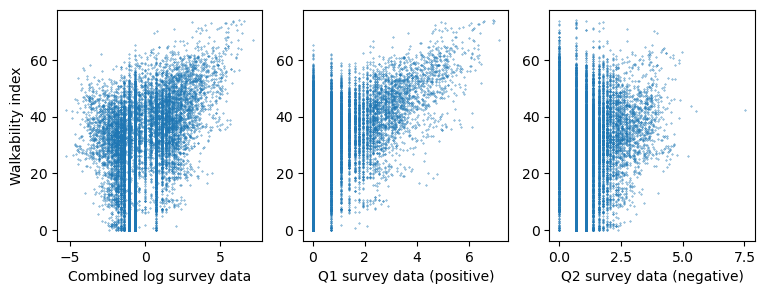

In [36]:
survey_data = survey_mean_logs
index_data = ygrid_index

survey_mask = survey_data_mask#[130:230,390:490]
flat_survey_mask = survey_mask.reshape(yflat_index.shape)

survey_data_flat = survey_data.reshape(yflat_index.shape,)[flat_survey_mask]
index_data_flat = index_data.reshape(yflat_index.shape)[flat_survey_mask]

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].scatter(survey_data_flat, index_data_flat, s=0.1)
ax[0].set_xlabel('Combined log survey data')
ax[0].set_ylabel('Walkability index')
ax[1].scatter(survey_pos_log.reshape(yflat_index.shape)[flat_survey_mask], index_data_flat, s=0.1)
ax[1].set_xlabel('Q1 survey data (positive)') 
ax[2].scatter(survey_neg_log.reshape(yflat_index.shape)[flat_survey_mask], index_data_flat, s=0.1)
ax[2].set_xlabel('Q2 survey data (negative)')
pearsonr(survey_data_flat, index_data_flat), pearsonr(survey_pos_log.reshape(yflat_index.shape)[flat_survey_mask], index_data_flat), pearsonr(survey_neg_log.reshape(yflat_index.shape)[flat_survey_mask], index_data_flat)

## Visualisation

In [18]:
sydney_shape = gpd.read_file("C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\Australia waterways shape\\sea near Sydney.gpkg")
sydney_water = sydney_shape.to_crs(hulls.crs)

In [19]:
min_x, max_x, min_y, max_y = 326000, 343184, 6259900, 6241400

x_min_cell = int((min_x - x_mini)/kResolution + 1)
x_max_cell = int((max_x - x_mini)/kResolution + 1)
y_min_cell = int((min_y - y_mini)/kResolution + 1)
y_max_cell = int((max_y - y_mini)/kResolution + 1)

bbox = [min_x, max_x, min_y, max_y]
bounding_box = box(bbox[0], bbox[2], bbox[1], bbox[3])
water_crop = sydney_water.intersection(bounding_box)

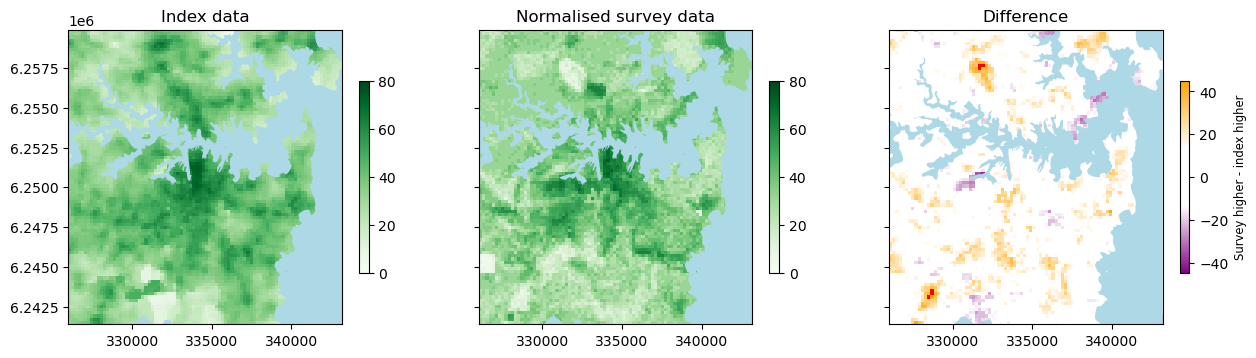

In [30]:
mean_log_img_norm = (index_max - index_min) * (survey_mean_logs - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min()) / (survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].max() - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min())

diff_log = ygrid_index - mean_log_img_norm

colors = ["purple", "white", "white", "white", "orange"]
nodes = [0.0, 0.35, 0.5, 0.65, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
palette = cmap2.with_extremes(over='r', under='orange', bad='lightgrey')   #plt.cm.PuOr

images = [ygrid_index, mean_log_img_norm, diff_log]
names = ['Index data', 'Normalised survey data', 'Difference']
vmins = [0, 0, -45]
vmaxs = [80, 80, 45]

cmaps = ['Greens', 'Greens', palette]
labels = [None, None, 'Survey higher - index higher']
cbs = [True, True, True]
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)

for image, name, ax, vi, va, cmap, label, cbtrue in zip(images, names, axs.ravel(), vmins, vmaxs, cmaps, labels, cbs):
    ygridm = image #np.ma.masked_where((index_data_mask)==0, image)
    im = ax.imshow(ygridm[y_max_cell:y_min_cell, x_min_cell:x_max_cell], origin='lower', extent=[min_x, max_x, max_y, min_y], cmap=cmap,
                   norm = mpl.colors.Normalize(vmin=vi, vmax=va))
    water_crop.plot(ax=ax, color='lightblue')
    if cbtrue:
        cb = fig.colorbar(im, ax=ax, shrink=0.5)
        cb.set_label(label, fontsize='small')
    ax.set_title(name)

plt.savefig("comparison_22_9.jpg", dpi=2400)

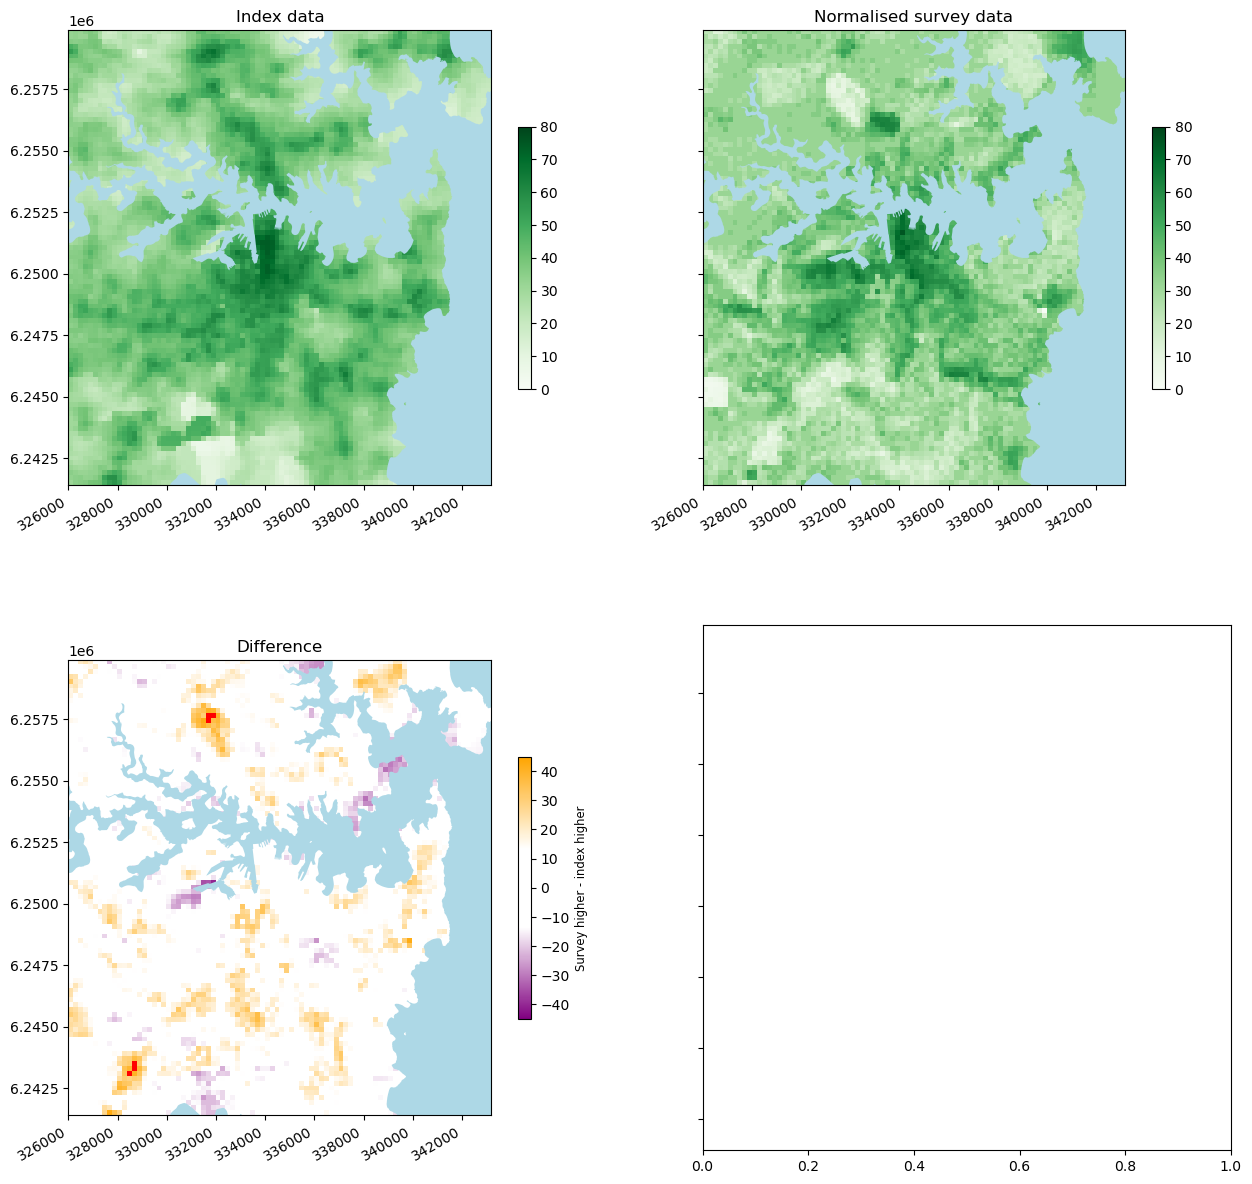

In [35]:
# Larger plots on a 2x2 grid.

mean_log_img_norm = (index_max - index_min) * (survey_mean_logs - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min()) / (survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].max() - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min())

diff_log = ygrid_index - mean_log_img_norm

colors = ["purple", "white", "white", "white", "orange"]
nodes = [0.0, 0.35, 0.5, 0.65, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
palette = cmap2.with_extremes(over='r', under='orange', bad='lightgrey')   #plt.cm.PuOr

images = [ygrid_index, mean_log_img_norm, diff_log]
names = ['Index data', 'Normalised survey data', 'Difference']
vmins = [0, 0, -45]
vmaxs = [80, 80, 45]

cmaps = ['Greens', 'Greens', palette]
labels = [None, None, 'Survey higher - index higher']
cbs = [True, True, True]
fig, axs = plt.subplots(2,2, figsize=(15,15), sharey=True)

for image, name, ax, vi, va, cmap, label, cbtrue in zip(images, names, axs.ravel(), vmins, vmaxs, cmaps, labels, cbs):
    ygridm = image #np.ma.masked_where((index_data_mask)==0, image)
    im = ax.imshow(ygridm[y_max_cell:y_min_cell, x_min_cell:x_max_cell], origin='lower', extent=[min_x, max_x, max_y, min_y], cmap=cmap,
                   norm = mpl.colors.Normalize(vmin=vi, vmax=va))
    water_crop.plot(ax=ax, color='lightblue')
    if cbtrue:
        cb = fig.colorbar(im, ax=ax, shrink=0.5)
        cb.set_label(label, fontsize='small')
    ax.set_title(name)

    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.savefig("comparison_22_9.jpg", dpi=2400)